In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
%matplotlib inline

# Quantum Monte Carlo
## Austin Nhung and Alex Matheson

This notebook is intended as an aide to understanding how quantum Monte Carlo methods are implemented. Variational and diffusion methods are both used, and both are written as a class. Classes, functions and variables are documented for your convenience.

## Diffusion Monte Carlo

In this method, the Schrodinger equation is re-written as a diffusion equation. A class has been written to perform the algorithm and provide graphable output. Since the method may not seem intuitive at first, the class has been modified immediately below to visualize what happens at each iteration in the algorithm. To account for this, the suggested number of walkers and iterations have been drastically reduced.

In [5]:
#Modified version of dmc class for visualizing individual walker paths

class dmc:
    
    def __init__(self, num_walkers_start=2000, target_walkers=2000, walkers_start_position =0.0,
                 num_steps = 1000, time_step = 0.1, e_r= 0., burn_in = 300, num_bins = 200, 
                 x_min = -10, x_max = 10, potential_type = 'harmonic'):
        
        #Initialization
        self.num_walkers_start =  num_walkers_start              #how many walkers to initialize at t=0
        self.walkers_start_position = walkers_start_position     #initial delta function position for walkers
        self.target_walkers = target_walkers                     #preferred number of walkers at equilibrium
        self.num_steps = num_steps                               #number of iterations of the simulation to run
        self.time_step = time_step                               #the unit of imaginary time between each step
        self.e_r = e_r                                           #the initial guess for the reference energy
        self.burn_in = burn_in                                   #how many iterations needed to reach equilibrium
        self.num_bins = num_bins                                 #the number of bins in the wavefunction histogram
        self.x_min = x_min                                       #the minimum of the histogram x range
        self.x_max = x_max                                       #the maximum of the histogram x range
        self.potential_type = potential_type                     #which potential function to use
        
        #self.walkers = np.full(num_walkers_start, walkers_start_position)
        self.walkers = np.zeros((num_walkers_start, 4 ))
        
    def potential(self,x):
        """Determines which included potential function to evaluate. Current choices: simple harmonic oscillator
        and morse potential"""
        
        if self.potential_type == 'harmonic':
            v = self.potential_harmonic(x)
        if self.potential_type == 'morse':
            v =self.potential_morse()
        return v

    def potential_harmonic(self,x):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
        """      
        v = 0.5*x**2
        return v

    def run_dmc(self):
        """Simulates a quantum system using the quantum diffusion method"""
        wave_function = np.zeros(self.num_bins)
        e_0 = []
        
        fig, ax = plt.subplots(1,2,figsize=(20,10), gridspec_kw = {'width_ratios':[3, 1]}, sharey=True)
        ax[0].set_xlim(0, self.num_steps)
        ax[0].set_ylim(-4., 4.)
        
        for i in range(self.num_steps):
            self.walkers[:,3] = self.walkers[:,1]
            self.walkers[:,2] = self.walkers[:,0]
            self.walkers[:,0] = i+1
            
            #Perform a random walk
            rows, cols = self.walkers.shape
            for j in range(rows):
                self.walkers[j,1] += np.random.normal() * np.sqrt(self.time_step)
            
            #Determine the weight function
            energy = np.zeros_like(self.walkers[:,1])                        #finding the weight for each walker
            for j in range(energy.size):
                energy[j] = 1. -(self.potential(self.walkers[j,1]) - self.e_r) * \
                              self.time_step + np.random.random()
            weight = np.int_(energy)                                         #convert to int per the algorithm
            new_walkers = np.zeros_like(self.walkers[:,1])                   #how many new walkers each walker spawns
            new_walkers = np.minimum(3, weight)

            #Make a new array of walkers
            keep = np.compress(new_walkers > 0, self.walkers, axis=0)        #get an array of each walker still existing
            duplicate1 = np.compress(new_walkers > 1, self.walkers, axis=0)  #get an array of each walker duplicated
            duplicate2 = np.compress(new_walkers > 2, self.walkers, axis=0)  #get an array of each walker twice duplicated
            self.walkers = np.append(keep, duplicate1, axis=0)               #combine the above arrays into a complete array of walkers
            self.walkers = np.append(self.walkers, duplicate2, axis=0)
            
            
            #Once burn-in is complete, add values to the histogram
            if i>self.burn_in:
                hist, bin_edges = np.histogram(self.walkers[:,1], 
                                  bins=self.num_bins, range=(self.x_min, 
                                  self.x_max))
                wave_function += hist                                        #add the walker distribution at this step to the total distribution
            e_0.append(np.mean(self.potential(self.walkers[:,1])))                            #E_0 estimate at this step
 
            #Adjust values for next iteration
            self.e_r = np.mean(self.potential(self.walkers[:,1])) - (self.walkers[:,1].size
                       - self.target_walkers) / (self.target_walkers)  
            
            points_start = np.array([self.walkers[:,0], self.walkers[:,1]]).T.reshape(-1, 1, 2)
            points_end = np.array([self.walkers[:,2], self.walkers[:,3]]).T.reshape(-1, 1, 2)
            lines = np.concatenate([points_start, points_end], axis=1)

            lc = mc.LineCollection(lines, linewidths=0.5)
            ax[0].add_collection(lc)
        
        wave_function = wave_function / np.trapz( wave_function, dx = 0.1 )
        bin_edges = bin_edges[:-1]
        ax[1].barh(bin_edges, wave_function, align='center')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('x Position')
        ax[0].set_title('DMC Walker Paths')
        ax[1].set_xlabel('Histogram Count')
        ax[1].set_title('Corresponding Histogram')
        fig.tight_layout()
     

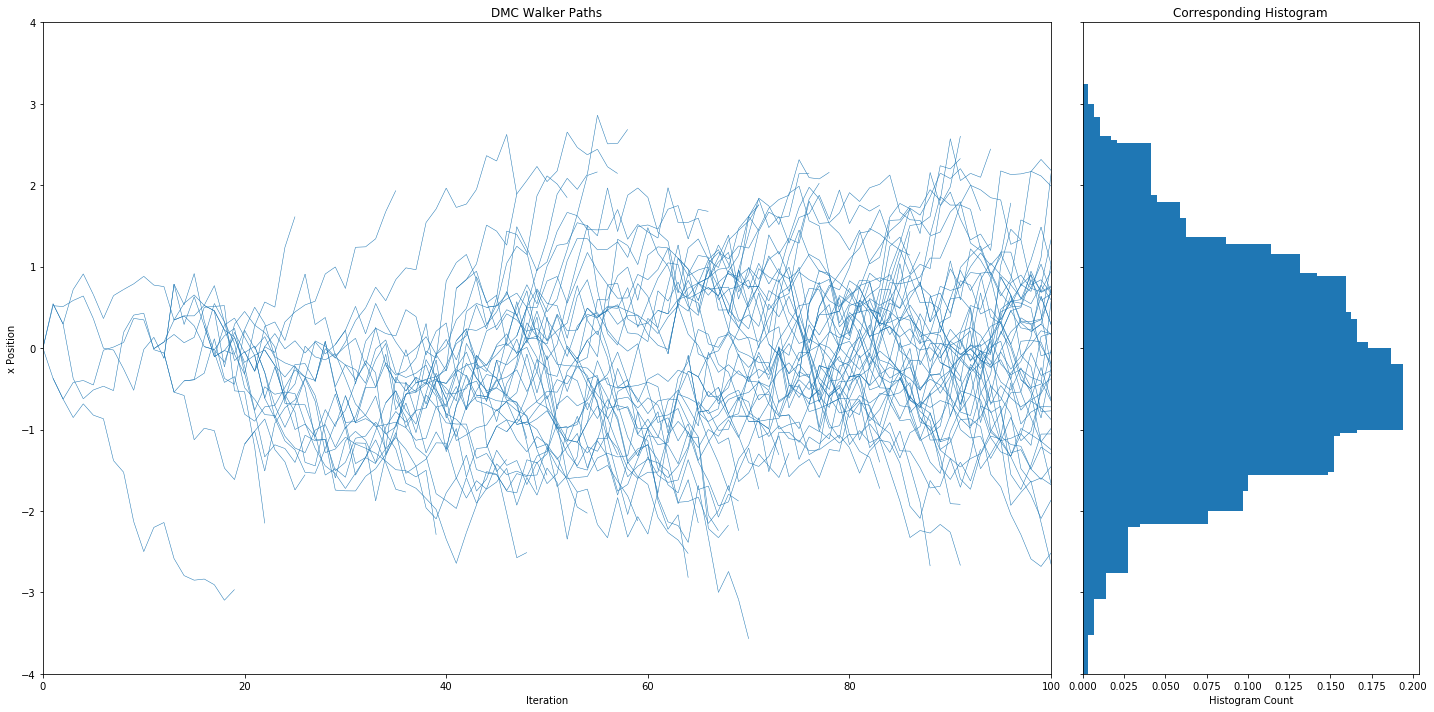

In [6]:
test = dmc(num_walkers_start = 3,          #Try changing these
           target_walkers=50,
           walkers_start_position = 0.0,
           num_steps=100, 
           burn_in=0, x_min=-4, x_max=4)   #Don't change these
test.run_dmc()

In the above graph, the left subplot shows the individual walkers traversing a one-dimensional potential. Each line represents the path of a walker. When the line ends, a walker has been destroyed. Walker paths diverge when walkers duplicate. The histogram on the right visualizes the positions of the walkers over the entire set of journeys on the right. 

In [9]:
#Quantum Monte Carlo - Diffusion

class dmc:
    
    def __init__(self, num_walkers_start=2000, target_walkers=2000, walkers_start_position =0.0,
                 num_steps = 1000, time_step = 0.1, e_r= 0., burn_in = 300, num_bins = 200, 
                 x_min = -10, x_max = 10, potential_type = 'harmonic'):
        
        #Initialization
        self.num_walkers_start =  num_walkers_start              #how many walkers to initialize at t=0
        self.walkers_start_position = walkers_start_position     #initial delta function position for walkers
        self.target_walkers = target_walkers                     #preferred number of walkers at equilibrium
        self.num_steps = num_steps                               #number of iterations of the simulation to run
        self.time_step = time_step                               #the unit of imaginary time between each step
        self.e_r = e_r                                           #the initial guess for the reference energy
        self.burn_in = burn_in                                   #how many iterations needed to reach equilibrium
        self.num_bins = num_bins                                 #the number of bins in the wavefunction histogram
        self.x_min = x_min                                       #the minimum of the histogram x range
        self.x_max = x_max                                       #the maximum of the histogram x range
        self.potential_type = potential_type                     #which potential function to use
        
        #self.walkers = np.full(num_walkers_start, walkers_start_position)
        self.walkers = np.linspace(x_min, x_max, num_walkers_start)
        
    def potential(self,x):
        """Determines which included potential function to evaluate. Current choices: simple harmonic oscillator
        and morse potential"""
        
        if self.potential_type == 'harmonic':
            v = self.potential_harmonic(x)
        if self.potential_type == 'morse':
            v =self.potential_morse(x)
        return v

    def potential_harmonic(self,x):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
        """      
        v = 0.5*x**2
        return v

    def potential_morse(self,x):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
                a     :: defining parameter - will be set to 1 for ease of solution
        """
        a = 1.
        v = 0.5*(np.exp( -2*a*x ) - 2*np.exp( -a*x ) )
        return v

    def run_dmc(self):
        """Simulates a quantum system using the quantum diffusion method. Performs random walks on 
        different 'walkers'. Walkers are stored as an array of current positions. After each iteration,
        histogram values are updated, and the estimated ground energy for that iteration recorded.
        Output:  wave_function :: an array of the histogram count for each position bin corresponding to the 
                                  ground state wavefunction
                 bin_edges     :: an array of the location of the left edge of each histogram bin
                 e_0           :: a list of ground state energies for each iteration"""
        
        wave_function = np.zeros(self.num_bins)
        e_0 = []
        
        for i in range(self.num_steps):
            #Perform a random walk
            for j in range(self.walkers.size):
                self.walkers[j] += np.random.normal() * np.sqrt(self.time_step)
            
            #Determine the weight function
            num_walkers_old = self.walkers.size
            energy = np.zeros_like(self.walkers)                     #finding the weight for each walker
            for j in range(self.walkers.size):
                energy[j] = 1. -(self.potential(self.walkers[j]) - self.e_r) * \
                          self.time_step + np.random.random()
            weight = np.int_(energy)                                 #convert to int per the algorithm
            new_walkers = np.zeros_like(self.walkers)                #how many new walkers each walker spawns
            new_walkers = np.minimum(3, weight)

            #Make a new array of walkers
            keep = np.compress(new_walkers > 0, self.walkers)        #get an array of each walker still existing
            duplicate1 = np.compress(new_walkers > 1, self.walkers)  #get an array of each walker duplicated
            duplicate2 = np.compress(new_walkers > 2, self.walkers)  #get an array of each walker twice duplicated
            self.walkers = np.append(keep, duplicate1)               #combine the above arrays into a complete array of walkers
            self.walkers = np.append(self.walkers, duplicate2)
            
            #Once burn-in is complete, add values to the histogram
            if i>self.burn_in:
                hist, bin_edges = np.histogram(self.walkers, 
                                  bins=self.num_bins, range=(self.x_min, 
                                  self.x_max))
                wave_function += hist                                #add the walker distribution at this step to the total distribution
            e_0.append(np.mean(self.potential(self.walkers)))                    #E_0 estimate at this step

            #Adjust values for next iteration
            self.e_r = np.mean(self.potential(self.walkers)) - (self.walkers.size
                       - self.target_walkers) / (self.target_walkers)      
            
        return wave_function, bin_edges, e_0


Mean E_0: 0.459868113675 Standard Deviation 0.111464985279


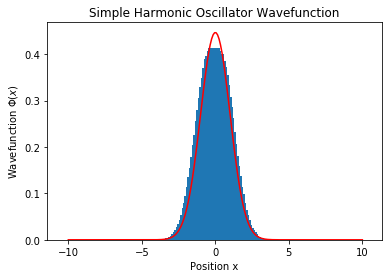

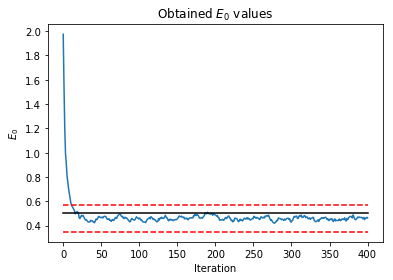

In [11]:
#Retrieve Histogram data
dmc_test_1 = dmc(target_walkers=2000, num_steps = 400, burn_in = 100)
wave, bins, e0 = dmc_test_1.run_dmc()

#Tidy data for plotting 
bins = bins[:-1]
wave = wave / np.trapz(wave, dx = 0.1)                   #Normalization
iters = np.linspace(-10, 10, 200)
func = (np.pi/0.125)**(-1./4.) * np.exp( -iters**2 / 2)  #Analytical Wave-function

#Plot the histogram and wavefunction
plt.figure(0)
plt.bar(bins, wave, align='center')
plt.plot(iters, func , 'r')
plt.xlabel('Position x')
plt.ylabel('Wavefunction $\Phi(x)$')
plt.title('Simple Harmonic Oscillator Wavefunction')

#Determining Ground State Energy Results and Expected Result
trial = np.linspace(0, len(e0), len(e0))
mean = np.full_like(trial, np.mean(e0[50:]))
stdev = np.full_like(trial, np.std(e0))
actual = np.full_like(trial, 0.5)
print('Mean E_0:', mean[0], 'Standard Deviation', stdev[0])

#Plotting Ground State Energy
plt.figure(1)
plt.plot(trial, e0, trial, actual, 'k', trial, mean + stdev, 'r--', trial, mean-stdev, 'r--')
plt.ylabel('$E_0$')
plt.xlabel('Iteration')
plt.title('Obtained $E_0$ values')

Mean E_0: -0.149940314096 Standard Deviation 0.024681734766


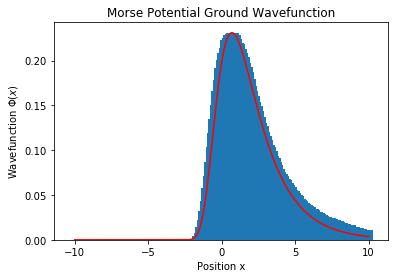

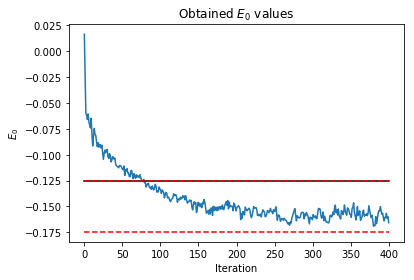

In [12]:
#Retrieve Histogram data
dmc_test_2 = dmc(target_walkers = 10000, num_steps = 400, burn_in = 40, potential_type = 'morse')
wave, bins, e0 = dmc_test_2.run_dmc()

#Tidy data for plotting 
wave = wave / np.trapz( wave, dx = 0.1 )
bins = bins[:-1]
iters = np.linspace(-10, 10, 200)
func = np.sqrt(2) * np.exp( -np.exp( -iters ) - iters / 2 )
func = func * np.amax(wave) / np.amax(func)

#Plot the histogram and wavefunction
plt.figure(0)
plt.bar(bins, wave, align='center')
plt.plot(iters, func , 'r')
plt.xlabel('Position x')
plt.ylabel('Wavefunction $\Phi(x)$')
plt.title('Morse Potential Ground Wavefunction')

#Determining Ground State Energy Results and Expected Result
trial = np.linspace(0, len(e0), len(e0))
mean = np.full_like(trial, np.mean(e0[50:]))
stdev = np.full_like(trial, np.std(e0))
actual = np.full_like(trial, -0.125)
print('Mean E_0:', mean[0], 'Standard Deviation', stdev[0])

#Plotting Ground State Energy
plt.figure(1)
plt.plot(trial, e0, trial, actual, 'k', trial, mean + stdev, 'r--', trial, mean-stdev, 'r--')
plt.ylabel('$E_0$')
plt.xlabel('Iteration')
plt.title('Obtained $E_0$ values')

-0.157239270422 0.0166567021491


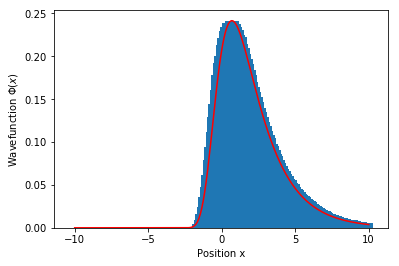

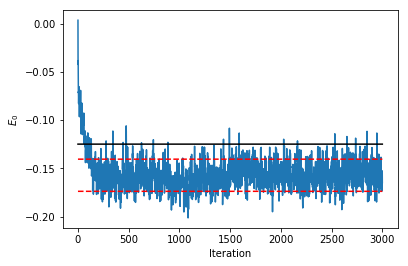

In [14]:
#Retrieve Histogram data
dmc_test_2 = dmc(target_walkers = 1000, num_steps = 3000, burn_in = 40, potential_type = 'morse')
wave, bins, e0 = dmc_test_2.run_dmc()

#Tidy data for plotting 
wave = wave / np.trapz( wave, dx = 0.1 )
bins = bins[:-1]
iters = np.linspace(-10, 10, 200)
func = np.sqrt(2) * np.exp( -np.exp( -iters ) - iters / 2 )
func = func * np.amax(wave) / np.amax(func)

#Plot the histogram and wavefunction
plt.figure(0)
plt.bar(bins, wave, align='center')
plt.plot(iters, func , 'r')
plt.xlabel('Position x')
plt.ylabel('Wavefunction $\Phi(x)$')

#Determining Ground State Energy Results and Expected Result
trial = np.linspace(0, len(e0), len(e0))
mean = np.full_like(trial, np.mean(e0[50:]))
stdev = np.full_like(trial, np.std(e0))
actual = np.full_like(trial, -0.125)
print(mean[0], stdev[0])

#Plotting Ground State Energy
plt.figure(1)
plt.plot(trial, e0, trial, actual, 'k', trial, mean + stdev, 'r--', trial, mean-stdev, 'r--')
plt.ylabel('$E_0$')
plt.xlabel('Iteration')